# 0 Import Libraries

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# 1 Data Preprocessing

## 1.1 Import the data and dump unnecessary columns

In [4]:
#Import dataset
BusStop = pd.read_csv('TransitPoint.csv')
BusStop.dropna(inplace=True)

In [5]:
BusStop = BusStop[['stop_latitude', 'stop_longitude']]
BusStop = BusStop.rename(columns={'stop_latitude':'lat', 'stop_longitude':'long'})
BusStop.head()

,lat,long
0,49.22727,-123.00697
1,49.21508,-123.06610
2,49.21802,-122.66670
3,49.33613,-123.14594
4,49.28246,-123.11828


## 1.2 Standardize the data

In [6]:
df = pd.DataFrame(preprocessing.scale(BusStop))
df.rename(columns = {i: BusStop.columns[i] for i in range(df.shape[1])}, inplace=True)

In [7]:
df

,lat,long
0,0.185760,-0.349337
1,0.032667,-0.686516
2,0.069590,1.590998
3,1.552917,-1.141791
4,0.878883,-0.984064
...,...,...
53951,0.712227,-1.783988
53952,1.580672,-1.346904
53953,-0.439671,1.604798
53954,1.010500,0.912477


# 2 Data Analysis

## 2.1 K-means

I expect DBSCAN to do better than K-means, because I do not expect the clusters to be convex. However, let's give K-means a try. We'll choose the number of clusters using silhouette score:

In [29]:
s_score = []
inertia_m = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(df)
    inertia_m.append(kmeans.score(df))
    s = silhouette_score(df, y_pred)
    s_score.append(s)

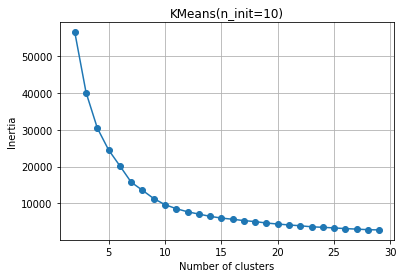

In [30]:
inertia = [-m for m in inertia_m]
plt.plot(np.arange(2, 30), inertia, marker ='o')
#plt.plot(np.linspace(2, 44, 22), inertia[0::2], marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('KMeans(n_init=10)')
plt.grid()
plt.show()

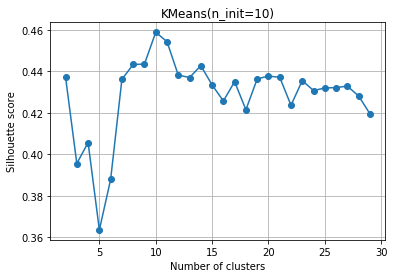

In [33]:
plt.plot(np.arange(2, 30), s_score, marker='o')
#plt.plot(np.arange(2, 26), s_score[0:24], marker = 'o')
#plt.plot(np.linspace(26, 44, 10), s_score[24::2], marker = 'o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('KMeans(n_init=10)')
plt.grid()
plt.show()

$k =$ 10 or 11 have the best scores. Let's look at each of these more closely, and see the clusters each give.

### 2.1.1 $k =10$

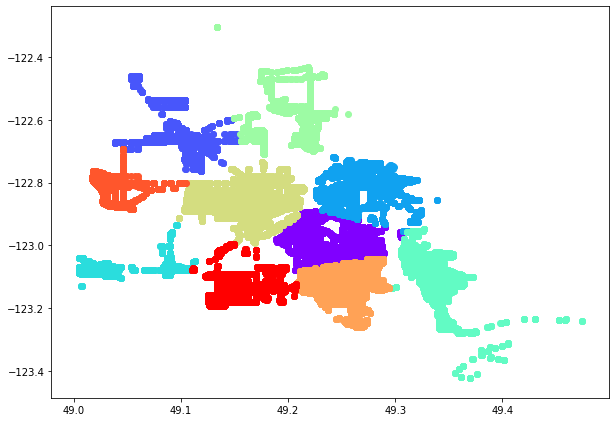

In [104]:
k = 10
kmeans_10 = KMeans(n_clusters=k)
y_pred_10 = kmeans_10.fit_predict(df)

labels = np.unique(y_pred_10)
n_clusters = len(labels)

clusters_10 = [[] for i in range(k)]

for j in range(y_pred_10.shape[0]):
    clusters_10[y_pred_10[j]].append(j)
        
colors = cm.rainbow(np.linspace(0, 1, k))
fig_dims = (10, 7.2)
fig, ax = plt.subplots(figsize=fig_dims)
for cluster_j, c in zip(clusters_10, colors):
    plt.scatter(BusStop.iloc[cluster_j, 0], BusStop.iloc[cluster_j, 1], color=c, cmap='viridis')

In [92]:
BusStop['cluster'] = pd.Series(y_pred_10)

BusStop.to_csv(r'./cluster_10.csv')

### 2.1.2 $k = 11$

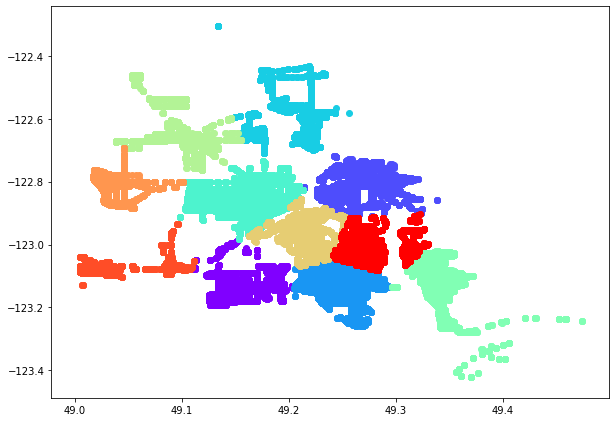

In [9]:
k = 11
kmeans_11 = KMeans(n_clusters=k)
y_pred_11 = kmeans_11.fit_predict(df)

labels = np.unique(y_pred_11)
n_clusters = len(labels)

clusters_11 = [[] for i in range(k)]

for j in range(y_pred_11.shape[0]):
    clusters_11[y_pred_11[j]].append(j)
        
colors = cm.rainbow(np.linspace(0, 1, k))
fig_dims = (10, 7.2)
fig, ax = plt.subplots(figsize=fig_dims)
for cluster_j, c in zip(clusters_11, colors):
    plt.scatter(BusStop.iloc[cluster_j, 0], BusStop.iloc[cluster_j, 1], color=c, cmap='viridis')


In [103]:
BusStop['cluster'] = pd.Series(y_pred_11)

BusStop.to_csv(r'./cluster_11.csv')

In addition to $k=10$ having a btter silhouette coefficient, it is clear that it also lands itself better to Metro Vancouver map than $k = 11$! This is the number we pick.

## 2.2 DBSCAN

I am so happy with the K-means result but I am also giving DBSCAN a try.

In [10]:
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

In [12]:
score = []
for eps in np.linspace(0.1, 0.5, 5):
    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=10).fit(df)
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    score_p = metrics.silhouette_score(df, labels)
    score.append((eps, score_p))

    print('Number of clusters: %d' % n_clusters_)
    print('Number of noise points: %d' % n_noise_)
    print("Silhouette Coefficient: %0.3f" % score_p)    
    print("*************************************************")

Number of clusters: 24
Number of noise points: 105
Silhouette Coefficient: -0.179
*************************************************
Number of clusters: 6
Number of noise points: 11
Silhouette Coefficient: 0.116
*************************************************
Number of clusters: 3
Number of noise points: 0
Silhouette Coefficient: 0.300
*************************************************
Number of clusters: 2
Number of noise points: 0
Silhouette Coefficient: 0.499
*************************************************
Number of clusters: 2
Number of noise points: 0
Silhouette Coefficient: 0.499
*************************************************


In [13]:
for i in np.unique(labels):
    print("The size of cluster", i, "is", len(labels[labels == i]))

The size of cluster 0 is 53934
The size of cluster 1 is 22


With reasonable silhouette score, we get one giant cluster and a tiny one. So, DBSCAN doesn't work very well on this.